v0.2 (Last Updated 2024/04/03)

# Problem 1: Principal Component Analysis (50\%)



### Introduction

Principal component analysis (PCA) is a technique that transforms high-dimension data into lower dimensions while retaining as much information as possible.

We do dimensionality reduction to convert the high $d$-dimensional dataset into $k$-dimensional data where $k<d$. It's possible for data to have a significantly larger variance on one axis compared to another. Typically, a higher variance suggests more information is present in that direction. Consequently, we can disregard dimensions with less variance since they contain less information.

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os

### Dataset

ORL Face Data The face data set used in this question is the ORL database of faces. Each face is a 56x46 array of pixels that has been flattened into a 1D-vector of length 2576. (Note: prior to plotting any images, you must reshape the image back into a 2D array of dimensions 56x46. See the last cell in the Introduction section for an example of how to do this).


- `X_train.csv`: each of the 360 lines contains data for a 56 × 46 face image.
- `Y_train.csv`: each of the 360 lines contains the label for the corresponding line in X\_train.csv.
- `X_test.csv`: each of the 40 lines contains data for a 56 x 46 face image.
- `Y_test.csv`: labels for face images in X\_test.csv.

In [3]:
# Upload the data to your google drive from Canvas then mount to the folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Use the command `%ls` ([IPython built-in magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html)) to locate your folder.



In [4]:
folder_path = "drive/MyDrive/EE443_2024/hw1/"

%ls -l drive/MyDrive/EE443_2024/hw1/

total 16530
drwx------ 2 root root     4096 Mar 27 05:00 data/
-rw------- 1 root root 16708325 Apr  4 20:56 data.zip
-rw------- 1 root root   198288 Apr  4 20:56 EE443___hw1__2024.pdf
-rw------- 1 root root    15117 May 16 03:00 ee443_hw1_release.ipynb


In [5]:
def load_data(filename):
    data = []
    with open(filename, 'r') as f:
        lines = csv.reader(f, delimiter=',')
        for line in lines:
            data.append([float(x) for x in line])
    data = np.array(data)
    print(f'Loaded {filename} with {len(data)} samples (shape: {data.shape})')
    return data

def vis_data_2d(data):
    # visualize a 2d data as an image
    assert len(data.shape) == 2
    plt.figure(figsize=(4, 2))
    plt.imshow(data, cmap='gray')
    plt.axis('off')

In [6]:
x_train = load_data(folder_path + "data/p1/X_train.csv")
x_test = load_data(folder_path + "data/p1/X_test.csv")
y_train = load_data(folder_path + "data/p1/Y_train.csv")
y_test = load_data(folder_path + "data/p1/Y_test.csv")

Loaded drive/MyDrive/EE443_2024/hw1/data/p1/X_train.csv with 360 samples (shape: (360, 2576))
Loaded drive/MyDrive/EE443_2024/hw1/data/p1/X_test.csv with 40 samples (shape: (40, 2576))
Loaded drive/MyDrive/EE443_2024/hw1/data/p1/Y_train.csv with 360 samples (shape: (360, 1))
Loaded drive/MyDrive/EE443_2024/hw1/data/p1/Y_test.csv with 40 samples (shape: (40, 1))


ID: 1


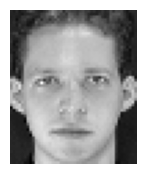

In [7]:
# Visualize an image
first_data_sample_in_train_img = x_train[0].reshape((56, 46))
first_data_sample_in_train_label = y_train[0][0]
vis_data_2d(first_data_sample_in_train_img)
print(f"ID: {int(first_data_sample_in_train_label)}")

### Principal Component Analysis

1-(a). Implementation of `my_pca()`

1. (Data Standardization) Compute the mean $\bar{x}$ of the 360 training faces, and subtract it from each training data point:

    \begin{align}
        \bar{x} = \frac{1}{N}\sum^{N}_{n=1} x_n
    \end{align}

2. (Covariance Matrix) Compute the covariance matrix $S$ for the 360 training faces using np.cov():
    \begin{align}
        S = \frac{1}{N}\sum^{N}_{n=1} (x_n - \bar{x})(x_n - \bar{x})^T.
    \end{align}

3. (Eigen-Decomposition) Apply eigen-decomposition on the obtained covariance matrix $S$ to obtain eigenvalues and eigenvectors using np.linalg.eigh():
    \begin{align}
        S = V \cdot \Lambda \cdot V^T &= \begin{bmatrix}
                                        \vdots & \vdots & & \vdots \\
                                        v_1 & v_2 & \dots & v_d \\
                                        \vdots & \vdots & & \vdots \\
                                        \end{bmatrix}
                                        \begin{bmatrix}
                                        \lambda_1 & 0 & \dots & 0 \\
                                        0 & \lambda_2 & \dots & 0 \\
                                        \vdots & \vdots & \ddots & \vdots \\
                                        0 & 0 & \dots & \lambda_d
                                        \end{bmatrix}
                                        \begin{bmatrix}
                                        \dots & v_1 & \dots \\
                                        \dots & v_2 & \dots \\
                                        & \vdots &  \\
                                        \dots & v_d & \dots \\
                                        \end{bmatrix}\\
        &= \begin{bmatrix}
            \lambda_1 v_1 & \lambda_1 v_1 & \dots & \lambda_d v_d
        \end{bmatrix}
        \begin{bmatrix}
            v_1\\ v_2\\ \vdots \\v_d
        \end{bmatrix} \\
        &= \lambda_1 v_1 v_1^T + \lambda_2 v_2 v_2^T + \dots + \lambda_d v_d v_d^T
    \end{align}
where
    \begin{equation}
                \Lambda = diag(\lambda_1, \lambda_2, ...),
    \end{equation}
and the corresponding eigenvectors $v$ are in:
    \begin{equation}
                V = [v_1 | v_2 | ...].
    \end{equation}

4. (Sort the Principal Components) Sort eigenvalue-eigenvector pairs by the value of eigenvalue.

In [8]:
def my_pca(x):
    # 1. Data Standardization: Comput the mean of x_train
    # TODO
    x_mean = np.mean(x, axis=0)
    # TODO

    print(f"x_mean Shape: {x_mean.shape}") # should be a shape of (2576,)

    # 2. Covariance Matrix: Compute the covariance matrix
    # TODO

    covariance_matrix = np.cov(x, rowvar=False)
    # TODO
    print(f"Covariance Matrix Shape: {covariance_matrix.shape}") # should be a shape of (2576, 2576)

    # 3. Eigen-Decomposition: Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    print(f"Eigenvalues Shape: {eigenvalues.shape}") # should be a shape of (2576,)
    print(f"Eigenvectors Shape: {eigenvectors.shape}") # should be a shape of (2576, 2576)

    # 4. Sort the eigenvalues in descending order
    # TODO
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # TODO

    return x_mean, covariance_matrix, sorted_eigenvalues, sorted_eigenvectors

def reproject(x, top_k_eigenvectors, x_mean):
    # TODO: calculate projection on mean-centered x
    # Calculate projection on mean-centered x
    x_centered = x - x_mean
    x_reproject = np.dot(x_centered, top_k_eigenvectors)
    # TODO
    return x_reproject

def reconstruct(x, top_k_eigenvectors, x_mean):
    # TODO
    x_reconstruct = ...
    # TODO
    print(f"x_reconstruct Shape: {x_reconstruct.shape}") # should be a shape of (N, k)

    return x_reconstruct

In [9]:
# Run the PCA on x_train
x_mean, covariance_matrix, sorted_eigenvalues, sorted_eigenvectors = my_pca(x_train)

x_mean Shape: (2576,)
Covariance Matrix Shape: (2576, 2576)
Eigenvalues Shape: (2576,)
Eigenvectors Shape: (2576, 2576)


1-(b). [5pts] Report the 5 largest eigenvalues you obtained from 1-(a).

In [10]:
print(sorted_eigenvalues[:5])

[718124.7403874  511371.79264177 276354.44752864 226580.92484444
 202114.8575661 ]


1-(c). [5pts] Plot the mean face and the eigenfaces corresponding to the 5 largest eigenvalues as 56 × 46 images from 1-(a).

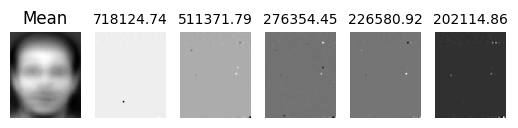

In [11]:
# TODO

mean_face = x_mean.reshape(56,46)
top_k_eigenface_almost = sorted_eigenvectors[:5]
top_k_eigenface = top_k_eigenface_almost.reshape(5,56,46)
top_k_eigenvalue = sorted_eigenvalues[:5]
# TODO

f, axarr = plt.subplots(1,6)

axarr[0].imshow(mean_face, cmap='gray')
axarr[0].set_title('Mean')
axarr[0].axis('off')

for i in range(5):
    axarr[i+1].imshow(top_k_eigenface[i], cmap='gray')
    axarr[i+1].set_title('{:.2f}'.format(top_k_eigenvalue[i]), fontsize=10)
    axarr[i+1].axis('off')

1-(d). [10pts] For image 0, 50, and 100 in the train\_X.csv, reconstruct the face $x$ with the first $k=1, 5, 10, 20 ,100, 200, 2576$ eigenfaces by:

\begin{equation}
    \hat x \approx \bar x + (x-\bar x) \cdot V_k \cdot V^T_k
\end{equation}


where $V_k$ is the matrix in which the columns are formed by the first $k$ eigenvectors. Also report the mean-square error between each of the reconstructed images and the original image.

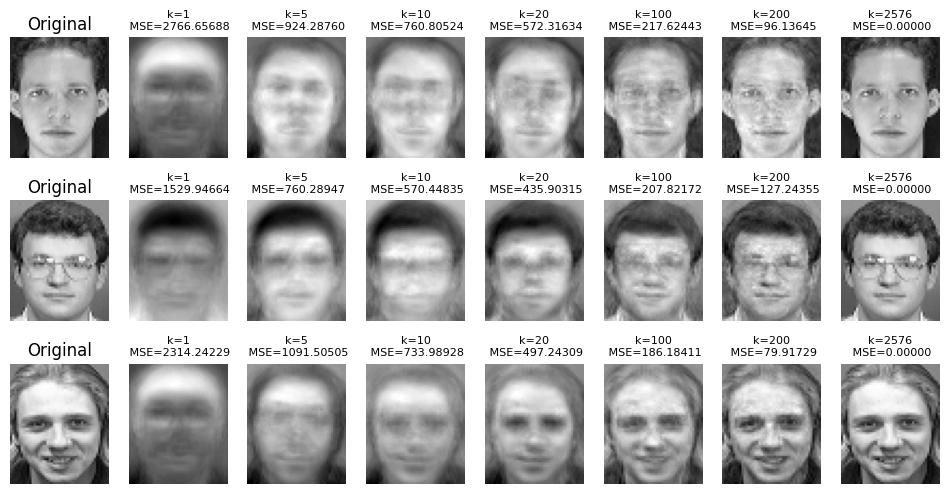

In [12]:
def get_top_k_eigenpairs(sorted_eigenvalues, sorted_eigenvectors,k):
  # TODO: function that returns the top k eigenvectors and corresponding eigenvalues
  top_k_eigenvalues = sorted_eigenvalues[:k]
  top_k_eigenvectors = sorted_eigenvectors[:, :k]
  return top_k_eigenvalues, top_k_eigenvectors

img_idxs = [0, 50, 100]
ks = [1, 5, 10, 20 ,100, 200, 2576]

n_row = len(img_idxs)
n_col = 1 + len(ks)

f, axarr = plt.subplots(n_row, n_col, figsize=(12, 6))

for i in range(n_row):
    img_idx = img_idxs[i]
    axarr[i][0].imshow(x_train[img_idx].reshape((56,46)), cmap='gray')
    axarr[i][0].set_title('Original')
    axarr[i][0].axis('off')

    for j, k in enumerate(ks):

      top_k_eigenvalues, top_k_eigenvectors = get_top_k_eigenpairs(sorted_eigenvalues, sorted_eigenvectors, k)

      # TODO
      x_mean = np.mean(x_train[img_idx])

      x_reconstruct = x_mean + np.dot((x_train[img_idx] - x_mean), np.dot(top_k_eigenvectors, top_k_eigenvectors.T))
      # TODO

      # TODO
      mse = np.mean((x_train[img_idx] - x_reconstruct) ** 2)
      # TODO

      axarr[i][j+1].imshow(x_reconstruct.reshape((56,46)), cmap='gray')
      axarr[i][j+1].set_title('k={}\n MSE={:.5f}'.format(k, mse), fontsize=8)
      axarr[i][j+1].axis('off')


1-(e). [5pts] Using k=200, run the code provided in the following cell to visualize the $10$ closest faces in the training dataset (measured by Euclidean distance in the projected space) to the first $5$ entries in the testing dataset. This code will compute the top-$1$, top-$5$, and top-$10$ accuracy of matching identities. (You do not need to make edits, just run this cell!)

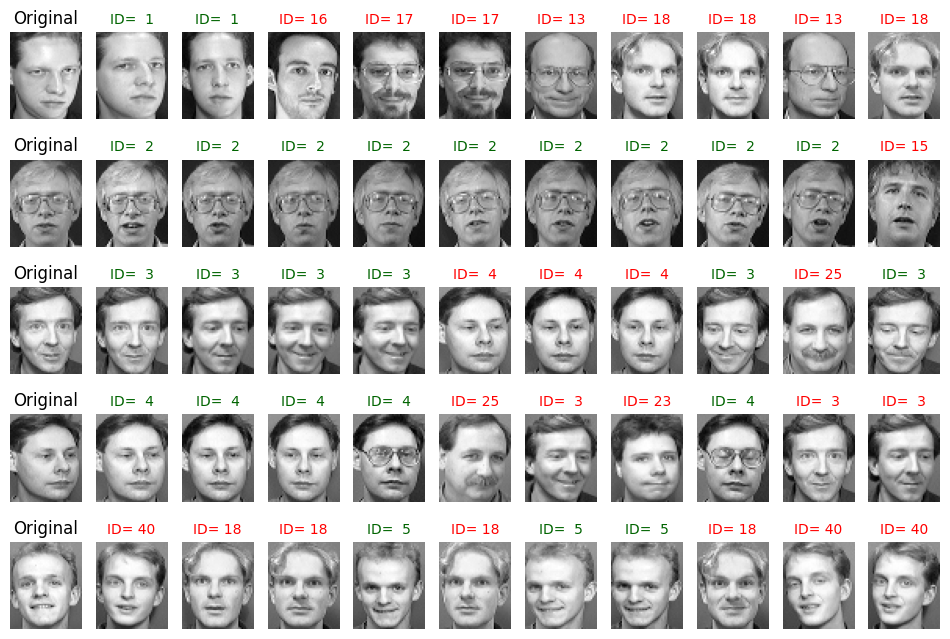

In [13]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2))

f, axarr = plt.subplots(5,11, figsize=(12, 8))

k=200
x_train_reduced = reproject(x_train,sorted_eigenvectors[:,:k], x_mean)
x_test_reduced = reproject(x_test,sorted_eigenvectors[:,:k], x_mean)

for i in range(5):
    axarr[i,0].imshow(x_test[i].reshape((56,46)), cmap='gray')
    axarr[i,0].set_title('Original')
    axarr[i,0].axis('off')

    face_distance = [euclidean(point, x_test_reduced[i]) for point in x_train_reduced]
    top_k_faces = np.argsort(face_distance, axis=0)[:10]

    for j in range(10):
        axarr[i, j+1].imshow(x_train[top_k_faces[j]].reshape((56,46)), cmap='gray')
        if y_train[top_k_faces[j]] != i+1:
            axarr[i, j+1].set_title('ID={:3d}'.format(int(y_train[top_k_faces[j]][0])), fontsize=10, color='red')
        else:
            axarr[i, j+1].set_title('ID={:3d}'.format(int(y_train[top_k_faces[j]][0])), fontsize=10, color='darkgreen')
        axarr[i, j+1].axis('off')

1-(f). [10pts] Questions

*  Based on the code in 1-(d), determine the minimum number \( n \) of eigenfaces required to ensure that the average reconstruction MSE on the test set is lower than \( 50 \). Analyze the reconstructed images and the corresponding errors to answer this question
*  What is the total computational complexity (in big $O$ notation) of Principal Component Analysis (PCA) in the context of face reconstruction, considering $N$ as the number of samples and $d$ as the number of features?
*   Explain the significance of selecting the appropriate number of principal components in PCA. How does it impact the quality of data representation and dimensionality reduction?
*   Provide a detailed example of a real-world application that benefits from using Principal Component Analysis (PCA). Describe the application and explain how PCA is utilized to enhance its effectiveness or efficiency.

